## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
#%%bash
#ls

In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp

from LOW_LEVEL_UTILITIES.utilities import show_batch, save_obj, load_obj, dataset_in_memory, check_datasets
from LOW_LEVEL_UTILITIES.utilities import train_one_epoch, evaluate_one_epoch, test_model, linear_decay_p_factor
from simulation_dictionary import SimulationDictionary 
from VAE.vae_model import Compositional_VAE

import numpy as np
import torch
import pyro
from pyro.infer import SVI, TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 
from pyro.optim import Adam, Adamax, SGD, RMSprop

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Get the data

In [4]:
#disk_data_dir = "/home/ldalessi/DATA/MULTI_DISK/"
#real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v3/"
#real_data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/DAPI_ONLY_v3/"
mMNIST_data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/MULTI_MNIST/"   
#real_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/REAL_DAPI_V4/"
#mMNIST_data_dir = "/home/ldalessi/DATA/MULTI_MNIST/"
#mMNIST_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_MNIST/"
#fashion_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_FashionMNIST/"
#real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v4/"
#real_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/REAL_DAPI_V4/"

#train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_train_large_hard",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_test_large_hard",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_v1",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_v1",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_no_bg",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_with_bg",use_cuda=torch.cuda.is_available())
test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_with_bg",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_no_bg",use_cuda=torch.cuda.is_available())

Dataset lenght: 2000
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


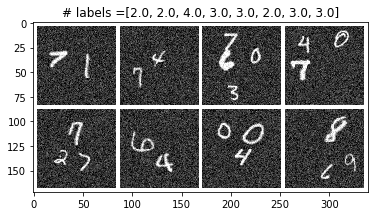

In [5]:
check_datasets(train_dataset)

Dataset lenght: 500
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cpu
torch.max(imgs) tensor(1.)
torch.min(imgs) tensor(0.)


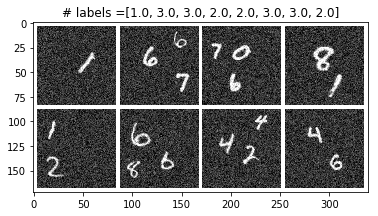

In [6]:
check_datasets(test_dataset)

tensor(4.)


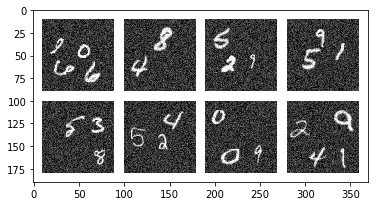

In [7]:
imgs_in, labels = train_dataset.load(8)
print(labels[0])
show_batch(imgs_in)

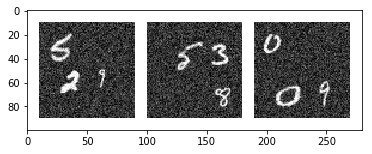

In [8]:
show_batch(imgs_in[2:-1:2])

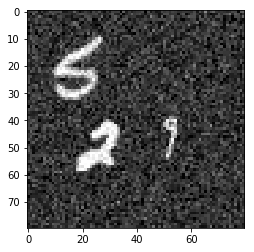

In [9]:
show_batch(imgs_in[2:3])

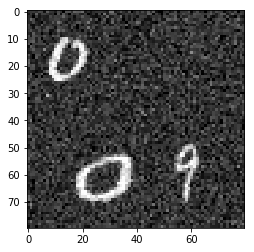

In [10]:
show_batch(imgs_in[-2:-1])

Text(0.5,0,'pixel intensity')

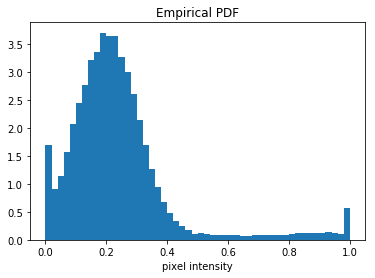

In [11]:
b = plt.hist(imgs_in.view(-1).cpu().numpy(), bins=50, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("pixel intensity")

Text(0.5,0,'Average intensity in box of size 15')

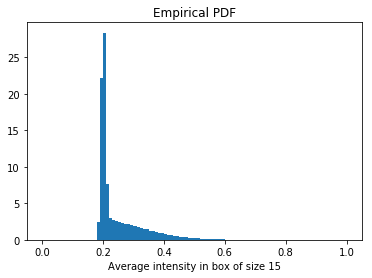

In [12]:
size=15
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

Text(0.5,0,'Average intensity in box of size 35')

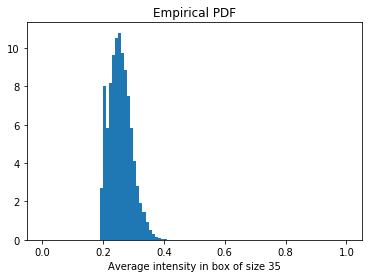

In [13]:
size=35
r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("Average intensity in box of size "+str(size))

# Generate the names

In [14]:
#write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#write_dir  = '/home/ldalessi/REPOS/spacetx-research/ARCHIVE/'
#write_dir  = '/home/ldalessi/buckets/VAE-ARCHIVE/'
write_dir  = '/Users/ldalessi/DAPI_unsupervised/ARCHIVE/'


#descriptor        = "DAPI_prevent_flow_nms_YES_random_p_v2"
descriptor        = "MNIST_v001"
#descriptor        = "FASHION_unit_cauchy_t4_v3"
#descriptor        = "MNIST_unit_cauchy_t4_v4"
#descriptor        = "DISK_v4"
#descriptor        = "DISK_speed"
name_vae          = descriptor+"_vae"
name_history      = descriptor+"_hystory"
name_hyper_params = descriptor+"_hyper_params"
epoch_restart     = 0
from_scratch = False


if(from_scratch):
    epoch_restart     = -1
    hyper_params=SimulationDictionary()
    hyper_params.check_consistency()
    print(hyper_params)
    
    min_loss = 99999999
    history_dict = {
        "train_loss" : [],
        "test_loss" : [],
        "fg_mu_cauchy" : [],
        "bg_mu_cauchy" : [],
        "bg_mu_normal" : [],
        "fg_sigma_cauchy" : [],
        "bg_sigma_cauchy" : [],
        "bg_sigma_normal" : []
        }
    
    vae = Compositional_VAE(hyper_params)
    vae.reset()
    
else:
    hyper_params = load_obj(write_dir,name_hyper_params+"_"+str(epoch_restart))
    hyper_params.check_consistency()
    print(hyper_params)
    history_dict = load_obj(write_dir,name_history+"_"+str(epoch_restart))
    min_loss = min(history_dict["test_loss"])
    vae = Compositional_VAE.load(hyper_params,write_dir,name_vae+"_"+str(epoch_restart))

save_obj(hyper_params,write_dir,name_hyper_params+"_write_test")

{'SD.width': 28, 'SD.dim_h1': -1, 'SD.dim_h2': -1, 'ZWHAT.dim': 50, 'ZMASK.dim': 50, 'REGULARIZATION.volume_mask_min': 0.0, 'REGULARIZATION.volume_mask_max': 500.0, 'REGULARIZATION.volume_mask_expected': 300.0, 'REGULARIZATION.randomize_nms_factor': 0.2, 'REGULARIZATION.p_corr_factor': 0.0, 'REGULARIZATION.lambda_small_box_size': 0.0, 'REGULARIZATION.lambda_mask_volume_fraction': 1.0, 'REGULARIZATION.lambda_mask_volume_absolute': 0.0, 'REGULARIZATION.lambda_tot_var_mask': 0.0, 'REGULARIZATION.lambda_overlap': 0.0, 'REGULARIZATION.LOSS_ZMASK': 0.0, 'REGULARIZATION.LOSS_ZWHAT': 10.0, 'PRIOR.width_zmask': 0.01, 'PRIOR.width_zwhat': 0.01, 'PRIOR.n_objects_max': 30, 'PRIOR.n_objects_expected': 10, 'PRIOR.size_object_min': 10, 'PRIOR.size_object_max': 40, 'PRIOR.size_object_expected': 20, 'IMG.size_raw_image': 80, 'IMG.ch_in_description': ['DAPI'], 'UNET.N_max_pool': 4, 'UNET.N_up_conv': 2, 'UNET.CH_after_first_two_conv': 32, 'UNET.N_prediction_maps': 1, 'NMS.p_threshold': 0.0, 'NMS.overlap_

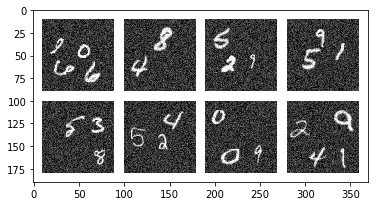

In [15]:
show_batch(imgs_in)

At layer l=  0  we have w_h_j_rf_wloc_hloc=  0 (80, 80, 1, 1, 0.5, 0.5)
At layer l=  1  we have w_h_j_rf_wloc_hloc=  1 (80, 80, 1.0, 5, 0.5, 0.5)
At layer l=  2  we have w_h_j_rf_wloc_hloc=  2 (40, 40, 2.0, 6, 1.0, 1.0)
At layer l=  3  we have w_h_j_rf_wloc_hloc=  3 (40, 40, 2.0, 14, 1.0, 1.0)
At layer l=  4  we have w_h_j_rf_wloc_hloc=  4 (20, 20, 4.0, 16, 2.0, 2.0)
At layer l=  5  we have w_h_j_rf_wloc_hloc=  5 (20, 20, 4.0, 32, 2.0, 2.0)
At layer l=  6  we have w_h_j_rf_wloc_hloc=  6 (10, 10, 8.0, 36, 4.0, 4.0)
At layer l=  7  we have w_h_j_rf_wloc_hloc=  7 (10, 10, 8.0, 68, 4.0, 4.0)
At layer l=  8  we have w_h_j_rf_wloc_hloc=  8 (5, 5, 16.0, 76, 8.0, 8.0)
At layer l=  9  we have w_h_j_rf_wloc_hloc=  9 (5, 5, 16.0, 140, 8.0, 8.0)
At layer l=  10  we have w_h_j_rf_wloc_hloc=  10 (10, 10, 8.0, 156, 4.0, 4.0)
At layer l=  11  we have w_h_j_rf_wloc_hloc=  11 (10, 10, 8.0, 188, 4.0, 4.0)
At layer l=  12  we have w_h_j_rf_wloc_hloc=  12 (20, 20, 4.0, 196, 2.0, 2.0)
At layer l=  13  we ha

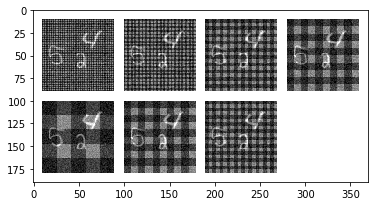

In [16]:
vae.inference.unet.describe_receptive_field(imgs_in)
img_with_grid = vae.inference.unet.show_grid(imgs_in)
print(img_with_grid.shape)
show_batch(img_with_grid[5])

In [17]:
#putative_imgs,putative_masks,background,c = vae.model()
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)
#print("max(putative_imgs)",torch.max(putative_imgs))

In [18]:
#show_batch(background)

In [19]:
#show_batch(putative_imgs[0])

In [20]:
#show_batch(putative_masks[0])
#print(torch.min(putative_masks),torch.max(putative_masks))

In [21]:
#imgs_prior = vae.generate_synthetic_data(N=2)
#show_batch(imgs_prior[:8,:1,:,:])
#print("imgs_prior.shape",imgs_prior.shape)
#print("type(imgs_prior)",type(imgs_prior))
#print("imgs_prior.device",imgs_prior.device)
#print("torch.max(imgs_prior)",torch.max(imgs_prior))
#print("torch.min(imgs_prior)",torch.min(imgs_prior))

In [22]:
#putative_imgs,putative_masks,background,c = vae.model(imgs_prior.cuda())
##putative_imgs,pixel_weights,background,c = vae.model(imgs_prior)
#
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)

In [23]:
#rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(imgs_prior,True)
#
#print("rec_img.shape",rec_img.shape)
#print("min, max of rec_img)",torch.min(rec_img),torch.max(rec_img))
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("logp.logp_off.shape",logp.logp_off.shape)
#print("logp.logp_on_cauchy.shape",logp.logp_on_cauchy.shape)
#print("logp.logp_on_normal.shape",logp.logp_on_normal.shape)
#print("reg.small_box_size.shape",reg.small_box_size.shape)
#print("reg.big_mask_volume.shape",reg.big_mask_volume.shape)
#print("reg.tot_var_mask.shape",reg.tot_var_mask.shape)
#print("reg.overlap_mask.shape",reg.overlap_mask.shape)
#show_batch(rec_img[:8,:,:,:])

### Debug model and guide

In [24]:
#print("TEST SAMPLE")
#test_model(vae.model, 
#           vae.guide, TraceGraph_ELBO())
#
#print("TEST PARALLEL ENUM")
#test_model(vae.model, 
#           config_enumerate(vae.guide, "parallel"), 
#           TraceEnum_ELBO(max_plate_nesting=2))

## Global parameters

In [25]:
TEST_FREQUENCY = 5
WRITE_FREQUENCY = 5
smoke_test= False
if(smoke_test):
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 6 
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 11
    
# batch size
batch_size = 5
time_scale_decay_prob = 40

# setup the optimizer
optimizer = Adam({"lr": 1.0e-3, "betas":(0.9, 0.999)})
#optimizer = RMSprop({"lr": 1.0e-4})

svi = SVI(vae.model, config_enumerate(vae.guide, "parallel"), optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))

# Actual train loop

In [26]:
# training loop
#epoch_restart = 100
for delta_epoch in range(1,-1):

#for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart
   
    vae.p_corr_factor = linear_decay_p_factor(epoch,time_scale_decay_prob)
    vae.randomize_nms_factor = 0.1
    vae.inference.nms.overlap_threshold=0.2
    vae.inference.nms.n_objects_max=30 
    vae.n_objects_max=30
    vae.train()   
    
    
    print("epoch,vae.p_corr_factor,vae.randomize_nms_factor",epoch,vae.p_corr_factor,vae.randomize_nms_factor)
    loss = train_one_epoch(svi, train_dataset, epoch, batch_size, verbose=(delta_epoch==1))
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
                
    history_dict["train_loss"].append(loss)
    try:
        history_dict["fg_mu_cauchy"].append(pyro.param("fg_mu_cauchy").item())
        history_dict["bg_mu_cauchy"].append(pyro.param("bg_mu_cauchy").item())
        history_dict["bg_mu_normal"].append(pyro.param("bg_mu_normal").item())
        
        history_dict["fg_sigma_cauchy"].append(pyro.param("fg_sigma_cauchy").item())
        history_dict["bg_sigma_cauchy"].append(pyro.param("bg_sigma_cauchy").item())
        history_dict["bg_sigma_normal"].append(pyro.param("bg_sigma_normal").item())      
        
    except:
        pass
            
    if(epoch % TEST_FREQUENCY == 0):      
        vae.p_corr_factor = 0.0
        vae.randomize_nms_factor = 0.0
        vae.inference.nms.overlap_threshold=0.2
        vae.inference.nms.n_objects_max=30 
        vae.n_objects_max=30
        vae.eval()
            
        loss = evaluate_one_epoch(svi, test_dataset, epoch, batch_size, verbose=(delta_epoch==1))        
        history_dict["test_loss"].append(loss)
            
        if(loss < min_loss):
            min_loss = loss
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
                
        if((loss == min_loss) or ((epoch % WRITE_FREQUENCY) == 0)):   
            # Save on disk
            vae.save_everything(write_dir,name_vae+"_"+str(epoch))
            save_obj(history_dict,write_dir,name_history+"_"+str(epoch))
            save_obj(hyper_params,write_dir,name_hyper_params+"_"+str(epoch))

# Check the results

In [27]:
history_dict

{'train_loss': [-23628.463380859375],
 'test_loss': [-35284.8039375],
 'fg_mu_cauchy': [0.8999999761581421],
 'bg_mu_cauchy': [0.14257308840751648],
 'bg_mu_normal': [],
 'fg_sigma_cauchy': [],
 'bg_sigma_cauchy': [],
 'bg_sigma_normal': []}

In [28]:
print(history_dict["train_loss"][-5:])
print(history_dict["test_loss"][-5:])

print(history_dict["fg_mu_cauchy"][-5:])
print(history_dict["bg_mu_cauchy"][-5:])
print(history_dict["bg_mu_normal"][-5:])

print(history_dict["fg_sigma_cauchy"][-5:])
print(history_dict["bg_sigma_cauchy"][-5:])
print(history_dict["bg_sigma_normal"][-5:])

[-23628.463380859375]
[-35284.8039375]
[0.8999999761581421]
[0.14257308840751648]
[]
[]
[]
[]


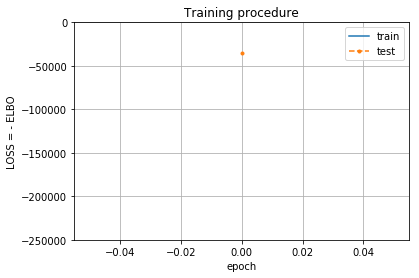

In [29]:
#plt.yscale('log')
y_shift=0
x_shift=0
sign =1.0
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), sign*np.array(history_dict["train_loss"])+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"]), TEST_FREQUENCY), sign*np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymin = -10000, ymax=-4000)
#plt.ylim(bottom=-250000, top=200000)
plt.ylim(bottom=-250000, top=0)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
from matplotlib import pyplot as plt
plt.savefig(write_dir+name_vae+'_train.png')

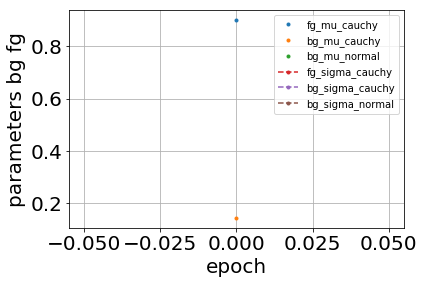

In [30]:
# Create a plot with the priors
fontsize=20
labelsize=20
plt.xlabel('epoch',fontsize=fontsize)
plt.ylabel('parameters bg fg',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=labelsize)

plt.plot(history_dict["fg_mu_cauchy"],'.')
plt.plot(history_dict["bg_mu_cauchy"],'.')
plt.plot(history_dict["bg_mu_normal"],'.')

plt.plot(history_dict["fg_sigma_cauchy"],'.--')
plt.plot(history_dict["bg_sigma_cauchy"],'.--')
plt.plot(history_dict["bg_sigma_normal"],'.--')

plt.legend(['fg_mu_cauchy','bg_mu_cauchy','bg_mu_normal',
            'fg_sigma_cauchy','bg_sigma_cauchy','bg_sigma_normal'])
plt.grid(True)
              
mp.savefig(write_dir+name_vae+'_hystory.png')

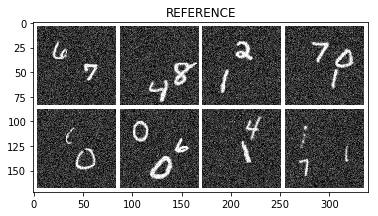

In [31]:
from matplotlib import pyplot as mp

reference_dir = '/Users/ldalessi/DAPI_unsupervised/REFERENCES/'

#reference_dir = '/home/ldalessi/DATA/REFERENCE/'
#reference_dir = '/home/jupyter/REPOS/spacetx-research/DATA/REFERENCES/'
#name='reference_mMNIST_v2'
#name='reference_disks_v3'
name='reference_dapi'
#name='reference_fashion'

# create image if necessary
#reference_imgs, labels=test_dataset.load(8)
#save_obj(reference_imgs ,reference_dir,name)

reference_imgs = load_obj(reference_dir,name)
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")
mp.savefig(write_dir+name+'.png')

z_nms.z_where.prob.shape torch.Size([8, 20, 1])
putative_masks.shape torch.Size([8, 20, 1, 80, 80])


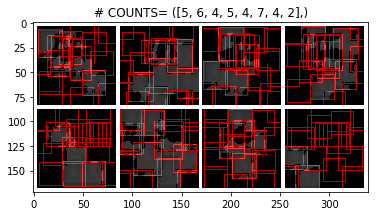

In [32]:
vae.p_corr_factor = 0.0
vae.randomize_nms_factor = 0.0
vae.inference.nms.overlap_threshold=0.2
vae.inference.nms.n_objects_max=20 
vae.n_objects_max=20

rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist(),
b=show_batch(rec_img[:8],nrow=4,npadding=4,title="# COUNTS= "+str(counts))
mp.savefig(write_dir+name_vae+'_rec_both.png')

In [33]:
chosen=7
print(z_where.prob[chosen].view(-1))

tensor([0.5844, 0.5045, 0.4524, 0.4389, 0.3668, 0.2794, 0.2761, 0.2570, 0.2410,
        0.2335, 0.1910, 0.1772, 0.1350, 0.1162, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])


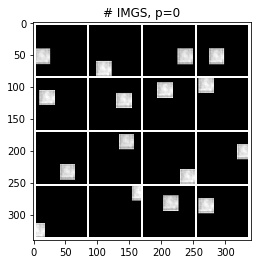

In [34]:
prob_tmp = np.round(z_where.prob[chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
prob_title = 0
b=show_batch(putative_imgs[chosen,:16],nrow=4,npadding=4,title="# IMGS, p="+str(prob_title))
mp.savefig(write_dir+name_vae+'_rec_imgs.png')

MNIST_v001_vae


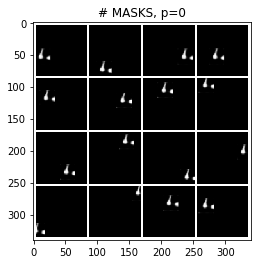

In [35]:
b=show_batch(putative_masks[chosen,:16],nrow=4,npadding=4,title="# MASKS, p="+str(prob_title))
print(name_vae)
mp.savefig(write_dir+name_vae+'_rec_masks.png')

tensor(0.4495)

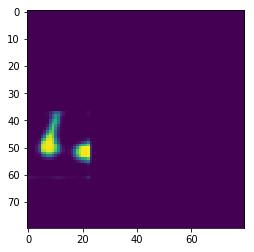

In [36]:
plt.imshow(putative_masks[chosen,0,0].cpu().numpy())
torch.max(putative_masks[chosen,0,0])

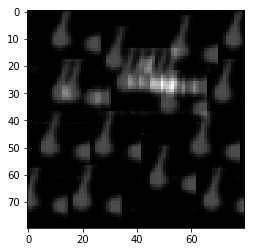

In [37]:
show_batch(torch.sum(putative_masks[chosen],dim=0,keepdim=True))

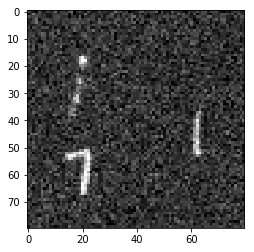

In [38]:
show_batch(reference_imgs[chosen,0][None,None,...])

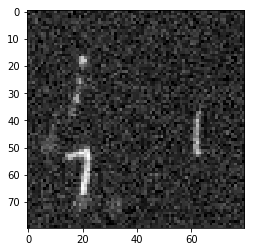

In [39]:
active = (z_where.prob[chosen] > 0.5)[...,None,None].float()
show_batch(torch.sum(active*putative_masks[chosen],dim=0,keepdim=True)+2*reference_imgs[chosen])
mp.savefig(write_dir+name_vae+'_debug0_imgs.png')

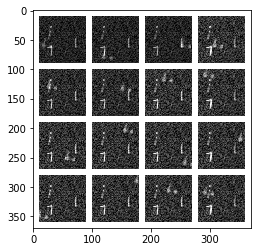

In [40]:
show_batch(putative_masks[chosen,:16]+reference_imgs[chosen,0])
mp.savefig(write_dir+name_vae+'_debug1_imgs.png')

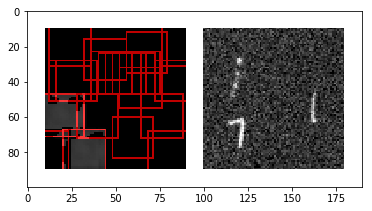

In [41]:
tmp1 = rec_img[chosen].unsqueeze(0)
tmp2 = reference_imgs[chosen].unsqueeze(0).expand(-1,3,-1,-1)
tmp = torch.cat((tmp1,tmp2),dim=0)
show_batch(tmp)
mp.savefig(write_dir+name_vae+'_debug2_imgs.png')

In [42]:
print("reg_small_box ----->",vae.lambda_small_box_size*reg.small_box_size[chosen,:16].detach().cpu())
print("reg_mask_fraction ->",vae.lambda_mask_volume_fraction*reg.mask_volume_fraction[chosen,:16].detach().cpu())
print("reg_mask_absolute ->",vae.lambda_mask_volume_absolute*reg.mask_volume_absolute[chosen,:16].detach().cpu())
print("reg_tot_var ------->",vae.lambda_tot_var_mask*reg.tot_var_mask[chosen,:16].detach().cpu())
print("reg_mask_overlap -->",vae.lambda_overlap*reg.overlap_mask[chosen,:16].detach().cpu())
print("mask_volumes ------>",torch.sum(putative_masks[chosen,:16],dim=(-2,-1)).view(-1))
print("probability object >",z_where.prob[chosen,:16].detach().cpu().view(-1))

reg_small_box -----> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_mask_fraction -> tensor([ 5.1419,  4.9585,  5.1162,  4.8906,  7.3467,  9.3786,  7.4474,  5.3213,
         4.8068,  4.9332,  8.4244, 15.4685,  9.2163, 18.2112, 18.3241,  7.2635])
reg_mask_absolute -> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_tot_var -------> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
reg_mask_overlap --> tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
mask_volumes ------> tensor([38.4907, 38.1627, 38.1775, 36.8399, 36.6303, 36.8626, 36.3567, 35.5127,
        35.5335, 36.2100, 30.1247, 24.3388, 28.7831, 22.7496, 36.0823, 37.1017])
probability object > tensor([0.5844, 0.5045, 0.4524, 0.4389, 0.3668, 0.2794, 0.2761, 0.2570, 0.2410,
        0.2335, 0.1910, 0.1772, 0.1350, 0.1162, 0.0000, 0.0000])


In [43]:
print("logp_off -------->",logp.logp_off[chosen,:16].detach().cpu())
print("logp_on_cauchy -->",logp.logp_on_cauchy[chosen,:16].detach().cpu())
print("logp_on_normal -->",logp.logp_on_normal[chosen,:16].detach().cpu())
print("probability object",z_where.prob[chosen,:16].detach().cpu().view(-1))

logp_off --------> tensor([235.9607, 245.6097, 276.5008, 301.6294,  94.1750, 209.5274, 191.0724,
        337.0545, 323.5595, 272.0349, 298.2515, 175.4660, 204.2025, 178.6117,
         69.9756, 229.5359])
logp_on_cauchy --> tensor([179.6329, 196.8203, 221.2304, 219.9098,  38.2447, 145.7028, 118.2225,
        258.1329, 245.6565, 191.2381, 228.0582, 121.0218, 139.9750, 124.5490,
         20.4281, 156.5544])
logp_on_normal --> tensor([209.3970, 222.3434, 251.4232, 264.8345,  69.2046, 181.1431, 157.7929,
        301.4080, 288.7750, 235.0636, 266.3020, 151.0123, 175.0892, 153.7101,
         47.7436, 196.7105])
probability object tensor([0.5844, 0.5045, 0.4524, 0.4389, 0.3668, 0.2794, 0.2761, 0.2570, 0.2410,
        0.2335, 0.1910, 0.1772, 0.1350, 0.1162, 0.0000, 0.0000])


Text(0.5,0,'Log prob')

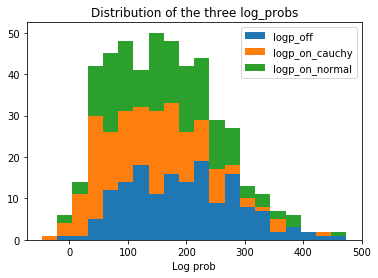

In [44]:
off=logp.logp_off.view(-1).detach().cpu().numpy()
on_c=logp.logp_on_cauchy.view(-1).detach().cpu().numpy()
on_n=logp.logp_on_normal.view(-1).detach().cpu().numpy()
a1 = plt.hist([off,on_c,on_n],bins=20,histtype="bar",stacked=True)
plt.legend(["logp_off","logp_on_cauchy","logp_on_normal"], loc='upper right')
plt.title("Distribution of the three log_probs")
plt.xlabel("Log prob")

# MAKE MOVIE

_0000 0.5
z_nms.z_where.prob.shape torch.Size([8, 20, 1])
putative_masks.shape torch.Size([8, 20, 1, 80, 80])
aaa
['MNIST_v001_vae_0000.png']


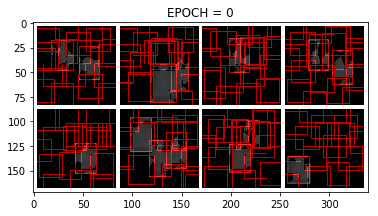

In [45]:
list_of_movie_files = []
for epoch in range(0,125,5):
    if(epoch<10):
        label ="_000"+str(epoch)
    elif(epoch<100):
        label = "_00"+str(epoch)
    elif(epoch<1000):
        label = "_0"+str(epoch)
    else:
        label = str(epoch)
    

    try:
        vae.load_everything(write_dir,name_vae+"_"+str(epoch))
        vae.p_corr_factor = linear_decay_p_factor(epoch,time_scale_decay_prob)
        print(label,vae.p_corr_factor)
        rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
        print("aaa")
        counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist()
        b=show_batch(rec_img[:8],nrow=4,npadding=4,title="EPOCH = "+str(epoch))
        name_output = name_vae+label+'.png'
        list_of_movie_files.append(name_output)
        mp.savefig(write_dir+name_output) 
    except:
        pass
    
print(list_of_movie_files)

In [48]:
rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)


z_nms.z_where.prob.shape torch.Size([8, 20, 1])
putative_masks.shape torch.Size([8, 20, 1, 80, 80])


## Check individual images

In [49]:
#from ipywidgets import interactive, IntSlider
#from PIL import Image
from IPython.display import Image

def show_frame(n):
    return Image(filename=write_dir+list_of_movie_files[n])  
    #image = Image.open(write_dir+list_of_movie_files[n], mode='r')
    #plt.imshow(image)
    #plt.show()    

# Widget does not work
#interactive_plot = interactive(show_frame,n=IntSlider(min=0, max=N_frames-1, step=1))
#output = interactive_plot.children[-1]
#interactive_plot

In [50]:
#write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#name_vae = "MNIST_unit_cauchy_t4_v2_vae_0"
#list_of_movie_files = []
#for file in os.listdir(write_dir):
#    if file.startswith(name_vae) and file.endswith(".png"):
#        list_of_movie_files.append(file)
N_frames = len(list_of_movie_files)
print(list_of_movie_files)
print(N_frames)

['MNIST_v001_vae_0000.png']
1


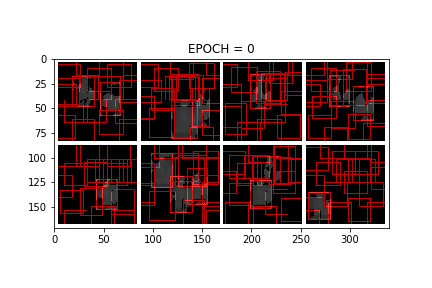

In [51]:
show_frame(0)

In [ ]:
show_frame(1)

In [ ]:
show_frame(16)

In [ ]:
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")